# Simple RAG with RL

## Setting Up the Environment

In [105]:
import numpy as np
import json
from typing import Dict, List, Tuple, Optional, Union

In [106]:
from openai import OpenAI
from dotenv import load_dotenv
import os

load_dotenv()
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

## Data Preprocessing

In [107]:
# 디렉토리에서 문서들을 불러오는 함수
def load_documents(directory_path: str) -> List[str]:
    """
    지정된 디렉토리에서 모든 텍스트 문서를 불러옵니다.

    Args:
        directory_path (str): 텍스트 파일들이 있는 디렉토리 경로

    Returns:
        List[str]: 각 텍스트 파일의 내용을 문자열로 담은 리스트
    """
    documents = []  # 문서 내용을 저장할 빈 리스트를 초기화합니다.
    for filename in os.listdir(directory_path):  # 디렉토리 내 모든 파일을 반복합니다.
        if filename.endswith(".txt"):  # 확장자가 .txt인 경우에만 처리합니다.
            # UTF-8 인코딩으로 파일을 읽고 그 내용을 리스트에 추가합니다.
            with open(os.path.join(directory_path, filename), 'r', encoding='utf-8') as file:
                documents.append(file.read())
    return documents  # 문서 내용이 담긴 리스트를 반환합니다.

In [108]:
# 문서들을 일정한 크기의 덩어리로 나누는 함수
def split_into_chunks(documents: List[str], chunk_size: int = 30) -> List[str]:
    """
    문서들을 지정된 단어 수만큼의 작은 덩어리로 나눕니다.

    Args:
        documents (List[str]): 나눌 대상이 되는 문서 문자열들의 리스트
        chunk_size (int): 각 덩어리에 포함될 최대 단어 수 (기본값은 30)

    Returns:
        List[str]: 각 덩어리를 문자열로 담은 리스트. 각 문자열은 최대 `chunk_size`개의 단어를 포함합니다.
    """
    chunks = []  # 덩어리를 저장할 빈 리스트를 초기화합니다.
    for doc in documents:  # 각 문서를 반복하면서 처리합니다.
        words = doc.split()  # 문서를 단어 단위로 나눕니다.
        # 지정된 크기만큼 단어들을 묶어 덩어리를 만듭니다.
        for i in range(0, len(words), chunk_size):
            chunk = " ".join(words[i:i + chunk_size])  # 단어들을 공백으로 연결하여 하나의 문자열로 만듭니다.
            chunks.append(chunk)  # 만든 덩어리를 리스트에 추가합니다.
    return chunks  # 덩어리 리스트를 반환합니다.

In [109]:
# 텍스트를 전처리하는 함수 (예: 소문자화, 특수문자 제거 등)
def preprocess_text(text: str) -> str:
    """
    입력된 텍스트를 소문자로 변환하고 특수문자를 제거하여 전처리합니다.

    Args:
        text (str): 전처리할 입력 텍스트

    Returns:
        str: 영숫자(알파벳 및 숫자)와 공백만 남긴 전처리된 텍스트
    """
    # 텍스트를 소문자로 변환합니다.
    text = text.lower()
    # 특수문자를 제거하고 영숫자와 공백만 남깁니다.
    text = ''.join(char for char in text if char.isalnum() or char.isspace())
    return text

In [110]:
# 모든 텍스트 덩어리에 전처리를 적용하는 함수
def preprocess_chunks(chunks: List[str]) -> List[str]:
    """
    모든 텍스트 덩어리에 전처리 작업을 적용합니다.

    Args:
        chunks (List[str]): 전처리할 텍스트 덩어리들의 리스트

    Returns:
        List[str]: 전처리된 텍스트 덩어리들의 리스트
    """
    # 리스트의 각 덩어리에 preprocess_text 함수를 적용합니다.
    return [preprocess_text(chunk) for chunk in chunks]

In [111]:
# 텍스트 파일이 들어 있는 디렉토리 경로를 지정합니다.
directory_path = "dataset"

# 지정된 디렉토리에서 모든 텍스트 문서를 불러옵니다.
documents = load_documents(directory_path)

# 불러온 문서들을 작은 텍스트 덩어리로 나눕니다.
chunks = split_into_chunks(documents)

# 각 덩어리에 대해 전처리 작업을 수행합니다 (예: 소문자화, 특수문자 제거).
preprocessed_chunks = preprocess_chunks(chunks)

In [112]:
# 전처리된 덩어리 중 처음 2개를 출력합니다. 각 덩어리는 처음 200자까지만 표시됩니다.
for i in range(2):
    # 슬라이싱을 사용하여 출력 길이를 200자로 제한합니다.
    print(f"Chunk {i+1}: {preprocessed_chunks[i][:50]} ... ")

Chunk 1: 양자 컴퓨팅 원리 발전 가능성 소개 양자 컴퓨팅은 전자 컴퓨터의 출현 이후 컴퓨팅 이론에서 ... 
Chunk 2: 현상을 활용하여 양자 비트qubit로 정보를 처리합니다 이러한 근본적인 차이로 인해 양자  ... 


## Document Embedding Generation

In [113]:
# 텍스트 덩어리 한 배치(batch)에 대해 임베딩을 생성하는 함수
def generate_embeddings_batch(chunks_batch: List[str], model: str = "text-embedding-3-small") -> List[List[float]]:
    """
    OpenAI 클라이언트를 사용하여 텍스트 덩어리 배치에 대한 임베딩을 생성합니다.

    Args:
        chunks_batch (List[str]): 임베딩을 생성할 텍스트 덩어리 배치
        model (str): 임베딩 생성을 위한 모델 이름 (기본값: "BAAI/bge-en-icl")

    Returns:
        List[List[float]]: 각 텍스트 덩어리에 대한 임베딩 리스트 (float 값들의 리스트)
    """
    # OpenAI 클라이언트를 사용하여 입력된 배치에 대한 임베딩을 생성합니다.
    response = client.embeddings.create(
        model=model,  # 사용할 임베딩 모델을 지정합니다.
        input=chunks_batch  # 텍스트 덩어리 배치를 입력으로 제공합니다.
    )
    # 응답에서 임베딩을 추출하여 반환합니다.
    embeddings = [item.embedding for item in response.data]
    return embeddings

In [114]:
# 모든 텍스트 덩어리에 대해 배치 단위로 임베딩을 생성하는 함수
def generate_embeddings(chunks: List[str], batch_size: int = 10) -> np.ndarray:
    """
    모든 텍스트 덩어리에 대해 배치 단위로 임베딩을 생성합니다.

    Args:
        chunks (List[str]): 임베딩을 생성할 텍스트 덩어리 리스트
        batch_size (int): 한 배치당 처리할 텍스트 덩어리 수 (기본값: 10)

    Returns:
        np.ndarray: 모든 덩어리에 대한 임베딩을 담고 있는 NumPy 배열
    """
    all_embeddings = []  # 모든 임베딩을 저장할 빈 리스트를 초기화합니다.

    # 지정된 배치 크기만큼 반복하면서 임베딩을 생성합니다.
    for i in range(0, len(chunks), batch_size):
        # 현재 배치에 해당하는 덩어리들을 추출합니다.
        batch = chunks[i:i + batch_size]
        # 해당 배치에 대해 임베딩을 생성합니다.
        embeddings = generate_embeddings_batch(batch)
        # 생성된 임베딩을 전체 리스트에 추가합니다.
        all_embeddings.extend(embeddings)

    # 전체 임베딩 리스트를 NumPy 배열로 변환하여 반환합니다.
    return np.array(all_embeddings)

In [115]:
# 임베딩을 파일로 저장하는 함수
def save_embeddings(embeddings: np.ndarray, output_file: str) -> None:
    """
    임베딩을 JSON 파일로 저장합니다.

    Args:
        embeddings (np.ndarray): 저장할 임베딩이 담긴 NumPy 배열
        output_file (str): 임베딩을 저장할 JSON 파일 경로

    Returns:
        None
    """
    # 지정된 파일을 UTF-8 인코딩으로 쓰기 모드로 엽니다.
    with open(output_file, 'w', encoding='utf-8') as file:
        # NumPy 배열을 리스트로 변환한 후 JSON 형식으로 저장합니다.
        json.dump(embeddings.tolist(), file)

In [116]:
# 임베딩 생성을 위해 텍스트 덩어리를 전처리합니다.
preprocessed_chunks = preprocess_chunks(chunks)

# 전처리된 덩어리들에 대해 임베딩을 생성합니다.
embeddings = generate_embeddings(preprocessed_chunks)

# 생성된 임베딩을 "embeddings.json"이라는 JSON 파일로 저장합니다.
save_embeddings(embeddings, "dataset/embeddings.json")

## Vector Store Implementation

In [117]:
import numpy as np
from typing import List

# 메모리 내 벡터 저장소를 딕셔너리 형태로 초기화합니다.
# 키는 고유한 정수값이며, 값은 임베딩과 해당 텍스트 덩어리를 담는 딕셔너리입니다.
vector_store: dict[int, dict[str, object]] = {}

# 임베딩과 해당하는 텍스트 덩어리를 벡터 저장소에 추가하는 함수
def add_to_vector_store(embeddings: np.ndarray, chunks: List[str]) -> None:
    """
    임베딩과 해당하는 텍스트 덩어리를 벡터 저장소에 추가합니다.

    Args:
        embeddings (np.ndarray): 추가할 임베딩이 담긴 NumPy 배열
        chunks (List[str]): 임베딩에 대응되는 텍스트 덩어리 리스트

    Returns:
        None
    """
    # 임베딩과 텍스트 덩어리를 동시에 반복하며 저장소에 추가합니다.
    for embedding, chunk in zip(embeddings, chunks):
        # 저장소의 현재 길이를 고유 키로 사용하여 항목을 추가합니다.
        vector_store[len(vector_store)] = {
            "embedding": embedding,
            "chunk": chunk
        }

In [118]:
# 두 벡터 간의 코사인 유사도를 계산하는 함수
def cosine_similarity(vec1: np.ndarray, vec2: np.ndarray) -> float:
    """
    두 벡터 간의 코사인 유사도를 계산합니다.

    Args:
        vec1 (np.ndarray): 첫 번째 벡터
        vec2 (np.ndarray): 두 번째 벡터

    Returns:
        float: 두 벡터 사이의 코사인 유사도 (-1에서 1 사이의 값)
    """
    # 두 벡터의 내적을 계산합니다.
    dot_product = np.dot(vec1, vec2)
    # 첫 번째 벡터의 크기(노름)를 계산합니다.
    norm_vec1 = np.linalg.norm(vec1)
    # 두 번째 벡터의 크기(노름)를 계산합니다.
    norm_vec2 = np.linalg.norm(vec2)
    # 내적을 두 벡터의 노름 곱으로 나누어 코사인 유사도를 반환합니다.
    return dot_product / (norm_vec1 * norm_vec2)

In [119]:
from typing import List

# 벡터 저장소에서 코사인 유사도를 기반으로 유사한 텍스트 덩어리를 검색하는 함수
def similarity_search(query_embedding: np.ndarray, top_k: int = 5) -> List[str]:
    """
    벡터 저장소에서 유사도 검색을 수행하고, 가장 유사한 텍스트 덩어리 top_k개를 반환합니다.

    Args:
        query_embedding (np.ndarray): 검색어에 대한 임베딩 벡터
        top_k (int): 반환할 가장 유사한 텍스트 덩어리의 개수 (기본값: 5)

    Returns:
        List[str]: 유사도가 높은 순서대로 정렬된 텍스트 덩어리 리스트 (top_k개)
    """
    similarities = []  # 유사도 점수와 해당 키를 저장할 리스트를 초기화합니다.

    # 벡터 저장소의 모든 항목을 반복하면서 유사도를 계산합니다.
    for key, value in vector_store.items():
        # 검색 임베딩과 저장된 임베딩 간의 코사인 유사도를 계산합니다.
        similarity = cosine_similarity(query_embedding, value["embedding"])
        # 키와 유사도를 튜플로 리스트에 추가합니다.
        similarities.append((key, similarity))

    # 유사도 점수를 기준으로 내림차순 정렬합니다.
    similarities = sorted(similarities, key=lambda x: x[1], reverse=True)

    # 유사도가 높은 순서대로 top_k개의 텍스트 덩어리를 반환합니다.
    return [vector_store[key]["chunk"] for key, _ in similarities[:top_k]]

In [120]:
# 주어진 질의(query)에 대해 관련 있는 문서 덩어리를 검색하는 함수
def retrieve_relevant_chunks(query_text: str, top_k: int = 5) -> List[str]:
    """
    주어진 질의 텍스트에 대해 가장 관련성 높은 문서 덩어리들을 검색합니다.

    Args:
        query_text (str): 관련 문서를 찾기 위한 질의 텍스트
        top_k (int): 반환할 관련 텍스트 덩어리 개수 (기본값: 5)

    Returns:
        List[str]: 관련도 순으로 정렬된 상위 top_k개의 텍스트 덩어리 리스트
    """
    # 질의 텍스트에 대한 임베딩을 생성합니다.
    query_embedding = generate_embeddings([query_text])[0]
    
    # 생성된 임베딩을 기반으로 유사한 문서 덩어리를 검색합니다.
    relevant_chunks = similarity_search(query_embedding, top_k=top_k)
    
    # 관련 텍스트 덩어리들을 반환합니다.
    return relevant_chunks

In [121]:
# 생성된 임베딩과 해당 전처리된 텍스트 덩어리를 벡터 저장소에 추가합니다.
add_to_vector_store(embeddings, preprocessed_chunks)

# 관련 문서 덩어리를 검색할 질의 텍스트를 정의합니다.
query_text = "양자 컴퓨팅(Quantum Computing)이란 무엇인가요?"

# 질의 텍스트에 대해 가장 관련 있는 텍스트 덩어리들을 벡터 저장소에서 검색합니다.
relevant_chunks = retrieve_relevant_chunks(query_text)

# 검색된 관련 텍스트 덩어리들을 출력합니다 (각 덩어리의 앞 50자만 표시).
for idx, chunk in enumerate(relevant_chunks):
    print(f"Chunk {idx + 1}: {chunk[:50]} ... ")

Chunk 1: 양자 컴퓨팅 원리 발전 가능성 소개 양자 컴퓨팅은 전자 컴퓨터의 출현 이후 컴퓨팅 이론에서 ... 
Chunk 2: 현상을 활용하여 양자 비트qubit로 정보를 처리합니다 이러한 근본적인 차이로 인해 양자  ... 
Chunk 3: 양자 컴퓨터는 여러 가능성을 동시에 처리할 수 있어 계산상의 이점을 얻을 수 있습니다 얽힘 ... 
Chunk 4: 컴퓨팅은 혁신적인 계산 패러다임이자 우리 시대의 가장 야심 찬 공학 프로젝트 중 하나입니다 ... 
Chunk 5: 기초 중첩 양자 컴퓨팅의 핵심은 중첩 원리에 있습니다 기존의 비트bit는 0 또는 1 중  ... 


## LLM Response Generation

In [122]:
# 질의에 대한 문맥 정보를 포함한 프롬프트를 생성하는 함수
def construct_prompt(query: str, context_chunks: List[str]) -> str:
    """
    검색된 문맥 정보와 함께 질의에 대한 프롬프트를 생성합니다.

    Args:
        query (str): 프롬프트를 구성할 질의 텍스트
        context_chunks (List[str]): 프롬프트에 포함할 관련 문맥 덩어리 리스트

    Returns:
        str: LLM에 입력할 최종 프롬프트 문자열
    """
    # 문맥 덩어리들을 개행 문자로 구분하여 하나의 문자열로 합칩니다.
    context = "\n".join(context_chunks)
    
    # LLM의 응답 방향을 안내하는 시스템 메시지를 정의합니다.
    system_message = (
        "당신은 유용한 AI 어시스턴트입니다. 반드시 제공된 문맥(context) 정보만 활용하여 질문에 답하십시오. "
        "문맥에 필요한 정보가 없을 경우 '이 질문에 답하기에 충분한 정보가 없습니다.'라고 답하십시오."
    )
    
    # 시스템 메시지, 문맥, 질의를 조합하여 최종 프롬프트를 구성합니다.
    prompt = f"System: {system_message}\n\nContext:\n{context}\n\nQuestion:\n{query}\n\nAnswer:"
    
    return prompt

In [127]:
# 프롬프트를 기반으로 OpenAI 호환 채팅 모델의 응답을 생성하는 함수
def generate_response(
    prompt: str,
    model: str = "gpt-4o-mini",
    max_tokens: int = 512,
    temperature: float = 1,
    top_p: float = 0.9,
    #top_k: int = 50
) -> str:
    """
    구성된 프롬프트를 기반으로 OpenAI 채팅 모델에서 응답을 생성합니다.

    Args:
        prompt (str): 채팅 모델에 전달할 입력 프롬프트
        model (str): 사용할 언어 모델 이름 (기본값: "google/gemma-2-2b-it")
        max_tokens (int): 생성할 응답의 최대 토큰 수 (기본값: 512)
        temperature (float): 샘플링 온도, 값이 높을수록 다양성이 증가함 (기본값: 1)
        top_p (float): 누적 확률 기반 샘플링의 확률 한계 (기본값: 0.9)
        top_k (int): 확률이 높은 상위 K개의 토큰만 고려 (기본값: 50)

    Returns:
        str: 언어 모델이 생성한 응답 문자열
    """
    # 클라이언트를 사용하여 채팅 응답을 생성합니다.
    response = client.chat.completions.create(
        model=model,  # 사용할 모델 지정
        max_tokens=max_tokens,  # 응답에서 생성할 최대 토큰 수
        temperature=temperature,  # 다양성을 위한 샘플링 온도
        top_p=top_p,  # 누적 확률 상한 (nucleus sampling)
        extra_body={  # 요청 본문에 추가할 항목
            #"top_k": top_k  # 상위 확률 토큰 개수 제한
        },
        messages=[  # 채팅 히스토리 형태의 입력 메시지 목록
            {
                "role": "user",  # 사용자 역할로 메시지를 전달
                "content": [  # 메시지 콘텐츠 (멀티모달도 가능)
                    {
                        "type": "text",  # 텍스트 유형 메시지
                        "text": prompt  # 실제 전달할 프롬프트 텍스트
                    }
                ]
            }
        ]
    )
    # 첫 번째 생성 응답의 텍스트만 반환
    return response.choices[0].message.content

## Basic RAG Pipeline

In [128]:
# 기본 RAG(Retrieval-Augmented Generation) 파이프라인을 수행하는 함수
def basic_rag_pipeline(query: str) -> str:
    """
    기본 RAG(Retrieval-Augmented Generation) 파이프라인을 수행합니다:
    관련 문서 검색 → 프롬프트 구성 → LLM 응답 생성

    Args:
        query (str): 응답을 생성할 사용자 질의

    Returns:
        str: 검색된 문맥을 기반으로 LLM이 생성한 응답
    """
    # 1단계: 주어진 질의에 대해 가장 관련 있는 텍스트 덩어리들을 검색합니다.
    relevant_chunks: List[str] = retrieve_relevant_chunks(query)
    
    # 2단계: 검색된 문맥과 질의를 바탕으로 프롬프트를 구성합니다.
    prompt: str = construct_prompt(query, relevant_chunks)
    
    # 3단계: 구성된 프롬프트를 기반으로 LLM의 응답을 생성합니다.
    response: str = generate_response(prompt)
    
    # 생성된 응답을 반환합니다.
    return response

## Evaluate the basic RAG pipeline

In [129]:
# 검증 데이터 파일을 읽기 모드로 열고, 내용을 딕셔너리로 불러옵니다.
with open('dataset/validation_rl.json', 'r') as file:
    validation_data = json.load(file)

# 기본 RAG 파이프라인을 테스트할 샘플 질의를 추출합니다.
sample_query = validation_data['basic_factual_questions'][0]['question']  # 질의 텍스트 추출
expected_answer = validation_data['basic_factual_questions'][0]['answer']  # 정답(기대 응답) 추출

# 샘플 질의와 기대 정답을 출력합니다.
print(f"샘플 질의: {sample_query}\n")
print(f"기대 정답: {expected_answer}\n")

샘플 질의: 큐비트가 중첩 상태에 있을 때의 수학적 표현은 무엇인가?

기대 정답: |ψ⟩ = α|0⟩ + β|1⟩으로, α와 β는 복소수이며 |α|² + |β|² = 1을 만족하여, 각각 상태 |0⟩ 또는 |1⟩로 측정될 확률 진폭을 나타낸다.



In [130]:
# RAG 파이프라인 실행 시작 메시지를 출력합니다.
print("RAG(Retrieval-Augmented Generation) 파이프라인을 실행합니다...")
print(f"질의: {sample_query}\n")

# RAG 파이프라인을 실행하고 모델 응답을 받아옵니다.
response = basic_rag_pipeline(sample_query)

# 모델 응답을 보기 좋게 출력합니다.
print("AI 응답:")
print("-" * 30)
print(response.strip())
print("-" * 50)

# 비교를 위해 정답(ground truth)을 출력합니다.
print("기대 정답:")
print("-" * 30)
print(expected_answer)
print("-" * 30)

RAG(Retrieval-Augmented Generation) 파이프라인을 실행합니다...
질의: 큐비트가 중첩 상태에 있을 때의 수학적 표현은 무엇인가?

AI 응답:
------------------------------
큐비트가 중첩 상태에 있을 때의 수학적 표현은 다음과 같습니다: ψ = α|0⟩ + β|1⟩, 여기서 α와 β는 복소수로 각각 상태 0 또는 1의 큐비트를 측정할 때의 확률 진폭을 나타내며, α² + β² = 1을 만족합니다.
--------------------------------------------------
기대 정답:
------------------------------
|ψ⟩ = α|0⟩ + β|1⟩으로, α와 β는 복소수이며 |α|² + |β|² = 1을 만족하여, 각각 상태 |0⟩ 또는 |1⟩로 측정될 확률 진폭을 나타낸다.
------------------------------


The simple RAG pipeline doesn't seem to perform well in its current state. The generated response is not only irrelevant to the ground truth but also misses critical information.

But don't worry! In the upcoming steps, we will implement a Reinforcement Learning-based RAG pipeline to address these shortcomings. This will help us improve the retrieval and generation process, making the responses more accurate and contextually relevant.

Stay tuned as we take our RAG pipeline to the next level!

단순한 RAG 파이프라인은 현재 상태에서는 제대로 작동하지 않는 것 같습니다. 생성된 응답은 실체적 진실과 관련이 없을 뿐만 아니라 중요한 정보를 누락하기도 합니다.

하지만 걱정하지 마세요! 다음 단계에서는 이러한 단점을 해결하기 위해 강화 학습 기반 RAG 파이프라인을 구현할 예정입니다. 이를 통해 검색 및 생성 프로세스를 개선하여 보다 정확하고 맥락에 맞는 응답을 제공할 수 있을 것입니다.

# Reinforcement Learning for RAG

In [131]:
# 강화 학습을 위한 state 표현을 정의하는 함수
def define_state(
    query: str, 
    context_chunks: List[str], 
    rewritten_query: str = None, 
    previous_responses: List[str] = None, 
    previous_rewards: List[float] = None
) -> dict:
    """
    강화 학습 에이전트를 위한 state 표현을 정의합니다.

    Args:
        query (str): 사용자의 원래 질의
        context_chunks (List[str]): Knowledge base에서 검색된 context 덩어리
        rewritten_query (str, optional): 원래 질의를 재구성한 쿼리 (선택 사항)
        previous_responses (List[str], optional): 이전에 생성된 응답들의 리스트
        previous_rewards (List[float], optional): 이전 행동에 대해 받은 reward들의 리스트

    Returns:
        dict: 현재 state를 나타내는 딕셔너리 (강화 학습 에이전트의 입력으로 사용됨)
    """
    state = {
        "original_query": query,  # 사용자가 입력한 원래 쿼리
        "current_query": rewritten_query if rewritten_query else query,  # 현재 사용 중인 쿼리 (재작성 가능)
        "context": context_chunks,  # Knowledge base에서 검색된 문맥 정보
        "previous_responses": previous_responses if previous_responses else [],  # 이전에 생성된 응답 히스토리
        "previous_rewards": previous_rewards if previous_rewards else []  # 각 응답에 대해 받은 보상 히스토리
    }
    return state

## Action Space 정의

In [132]:
from typing import List

# 강화 학습 에이전트가 선택할 수 있는 행동(action) 공간을 정의하는 함수
def define_action_space() -> List[str]:
    """
    강화 학습 에이전트가 수행할 수 있는 가능한 행동들을 정의합니다.

    포함되는 행동은 다음과 같습니다:
    - rewrite_query: 검색 성능 향상을 위해 원래 쿼리를 재작성
    - expand_context: 추가적인 문맥(context) 정보를 검색
    - filter_context: 관련 없는 문맥 정보를 제거
    - generate_response: 현재 쿼리와 문맥을 기반으로 응답 생성

    Returns:
        List[str]: 사용 가능한 행동들의 리스트
    """

    # 에이전트가 수행할 수 있는 행동들을 정의합니다.
    actions = ["rewrite_query", "expand_context", "filter_context", "generate_response"]
    return actions

In [133]:
# 응답 품질을 기반으로 보상(reward)을 계산하는 함수
def calculate_reward(response: str, ground_truth: str) -> float:
    """
    생성된 응답과 정답(ground truth)을 비교하여 보상 값을 계산합니다.

    응답과 정답의 임베딩 간 코사인 유사도를 사용하여
    응답이 얼마나 정확한지를 평가합니다.

    Args:
        response (str): RAG 파이프라인에서 생성된 응답
        ground_truth (str): 기대되는 정답 (정답 기준)

    Returns:
        float: -1과 1 사이의 보상 값. 값이 클수록 정답과 유사한 응답임을 의미합니다.
    """
    # 응답과 정답 각각에 대해 임베딩을 생성합니다.
    response_embedding = generate_embeddings([response])[0]
    ground_truth_embedding = generate_embeddings([ground_truth])[0]
    
    # 두 임베딩 간의 코사인 유사도를 계산하여 보상으로 사용합니다.
    similarity = cosine_similarity(response_embedding, ground_truth_embedding)
    return similarity

## Action Function Logic

In [134]:
# 더 나은 문서 검색을 위해 쿼리를 재작성하는 함수
def rewrite_query(
    query: str, 
    context_chunks: List[str], 
    model: str = "gpt-4o-mini", 
    max_tokens: int = 100, 
    temperature: float = 0.3
) -> str:
    """
    더 나은 문서 검색을 위해 LLM을 사용하여 쿼리를 재작성합니다.

    Args:
        query (str): 사용자의 원래 질의 텍스트
        context_chunks (List[str]): 현재까지 검색된 문맥 덩어리 리스트
        model (str): 쿼리 재작성을 위한 LLM 모델
        max_tokens (int): 재작성된 쿼리의 최대 토큰 수 (기본값: 100)
        temperature (float): 응답 다양성을 위한 샘플링 온도 (기본값: 0.3)

    Returns:
        str: 문서 검색 최적화를 위해 재작성된 쿼리
    """
    # LLM에 전달할 쿼리 재작성 프롬프트 구성
    rewrite_prompt = f"""
    당신은 쿼리 최적화 어시스턴트입니다. 주어진 질의를 더 효과적으로 재작성하여
    관련 있는 정보를 더 잘 검색할 수 있도록 도와주는 역할을 합니다.
    이 쿼리는 문서 검색에 사용될 예정입니다.

    원래 질의: {query}

    지금까지 검색된 문맥 기반:
    {' '.join(context_chunks[:2]) if context_chunks else '아직 문맥이 제공되지 않았습니다.'}

    더 구체적이고 정확한 정보를 검색할 수 있도록 질의를 재작성하세요.
    재작성된 질의:
    """

    # LLM을 호출하여 재작성된 쿼리를 생성합니다.
    response = client.chat.completions.create(
        model=model,  # 사용할 모델 지정
        max_tokens=max_tokens,  # 최대 토큰 수 제한
        temperature=temperature,  # 다양성을 위한 샘플링 온도
        messages=[
            {
                "role": "user",
                "content": rewrite_prompt
            }
        ]
    )

    # 생성된 응답에서 재작성된 쿼리를 추출하여 반환
    rewritten_query = response.choices[0].message.content.strip()
    return rewritten_query

In [135]:
# 추가적인 문맥 덩어리를 검색하여 context를 확장하는 함수
def expand_context(query: str, current_chunks: List[str], top_k: int = 3) -> List[str]:
    """
    문맥(context)을 확장하기 위해 추가적인 텍스트 덩어리(chunks)를 검색합니다.

    Args:
        query (str): 문맥을 확장하고자 하는 질의 텍스트
        current_chunks (List[str]): 현재까지 확보된 문맥 덩어리 리스트
        top_k (int): 새롭게 추가할 문맥 덩어리의 최대 개수 (기본값: 3)

    Returns:
        List[str]: 기존 문맥에 새로 추가된 문맥을 포함한 확장된 context 리스트
    """
    # 현재 확보된 문맥 수보다 많은 수를 요청하여 추가 문맥을 검색합니다.
    additional_chunks = retrieve_relevant_chunks(query, top_k=top_k + len(current_chunks))
    
    # 이미 포함된 문맥은 제외하고 새로운 문맥만 추려냅니다.
    new_chunks = []
    for chunk in additional_chunks:
        if chunk not in current_chunks:
            new_chunks.append(chunk)
    
    # 새로운 문맥 중 최대 top_k개만 추가하여 context를 확장합니다.
    expanded_context = current_chunks + new_chunks[:top_k]
    return expanded_context

In [136]:
# 가장 관련성 높은 문맥 덩어리만 남기도록 context를 필터링하는 함수
def filter_context(query: str, context_chunks: List[str]) -> List[str]:
    """
    context에서 가장 관련성 높은 덩어리들만 필터링하여 유지합니다.

    Args:
        query (str): 관련성을 계산할 기준이 되는 질의 텍스트
        context_chunks (List[str]): 필터링할 문맥 덩어리 리스트

    Returns:
        List[str]: 관련성 높은 문맥만 남긴 필터링된 context 리스트
    """
    if not context_chunks:
        return []
        
    # 질의 및 각 문맥 덩어리에 대해 임베딩을 생성합니다.
    query_embedding = generate_embeddings([query])[0]
    chunk_embeddings = [generate_embeddings([chunk])[0] for chunk in context_chunks]
    
    # 각 문맥 덩어리에 대해 질의와의 유사도 점수(관련성)를 계산합니다.
    relevance_scores = []
    for chunk_embedding in chunk_embeddings:
        score = cosine_similarity(query_embedding, chunk_embedding)
        relevance_scores.append(score)
    
    # 유사도 점수를 기준으로 문맥을 내림차순 정렬합니다.
    sorted_chunks = [x for _, x in sorted(zip(relevance_scores, context_chunks), reverse=True)]
    
    # 최대 5개의 가장 관련성 높은 문맥만 유지합니다 (필요 시 더 적게 유지 가능)
    filtered_chunks = sorted_chunks[:min(5, len(sorted_chunks))]
    
    return filtered_chunks

## Policy Network

In [137]:
# 현재 상태에 따라 행동을 선택하는 정책 네트워크 함수 (epsilon-greedy 전략 사용)
def policy_network(
    state: dict, 
    action_space: List[str], 
    epsilon: float = 0.2
) -> str:
    """
    현재 state를 기반으로 epsilon-greedy 전략을 사용하여 행동(action)을 선택하는 정책 네트워크를 정의합니다.

    Args:
        state (dict): 현재 환경의 상태. 쿼리, 문맥, 응답 히스토리, 보상 등을 포함합니다.
        action_space (List[str]): 에이전트가 선택할 수 있는 행동 목록
        epsilon (float): 무작위 탐색(exploration)을 수행할 확률 (기본값: 0.2)

    Returns:
        str: 선택된 행동 (action_space 내의 항목 중 하나)
    """
    # epsilon-greedy 전략: 무작위 탐색 vs. 현재 상태 기반 결정
    if np.random.random() < epsilon:
        # 탐색: 무작위로 행동을 선택
        action = np.random.choice(action_space)
    else:
        # 활용: 현재 상태를 기반으로 간단한 휴리스틱에 따라 최적의 행동 선택

        # 이전 응답이 전혀 없다면, 쿼리를 먼저 재작성
        if len(state["previous_responses"]) == 0:
            action = "rewrite_query"
        # 응답은 있었지만 보상이 낮다면 문맥을 확장
        elif state["previous_rewards"] and max(state["previous_rewards"]) < 0.7:
            action = "expand_context"
        # 문맥이 너무 많다면 필터링 시도
        elif len(state["context"]) > 5:
            action = "filter_context"
        # 그 외의 경우에는 응답 생성
        else:
            action = "generate_response"
    
    return action

## Single RL Step

In [138]:
# 한 번의 강화 학습 단계를 수행하는 함수
def rl_step(
    state: dict, 
    action_space: List[str], 
    ground_truth: str
) -> tuple[dict, str, float, str]:
    """
    한 번의 강화 학습 단계를 수행합니다: 행동 선택, 실행, 보상 계산까지 포함됩니다.

    Args:
        state (dict): 현재 환경의 상태 (쿼리, 문맥, 응답 기록, 보상 등 포함)
        action_space (List[str]): 에이전트가 선택할 수 있는 행동 목록
        ground_truth (str): 정답 응답 (보상 계산을 위한 기준)

    Returns:
        tuple: 다음 항목으로 구성된 튜플을 반환합니다:
            - state (dict): 행동 실행 후 업데이트된 상태
            - action (str): 선택된 행동
            - reward (float): 해당 행동으로 얻은 보상 값
            - response (str): 생성된 응답 (해당되는 경우)
    """
    # 정책 네트워크를 통해 행동 선택
    action: str = policy_network(state, action_space)
    response: str = None  # 생성된 응답 초기화
    reward: float = 0  # 보상 초기화

    # 선택된 행동을 실행합니다.
    if action == "rewrite_query":
        # 쿼리를 재작성하여 검색 품질 개선
        rewritten_query: str = rewrite_query(state["original_query"], state["context"])
        state["current_query"] = rewritten_query  # 상태 내 현재 쿼리 업데이트
        # 재작성된 쿼리로 새 context 검색
        new_context: List[str] = retrieve_relevant_chunks(rewritten_query)
        state["context"] = new_context  # context 업데이트

    elif action == "expand_context":
        # context 확장 (추가 문맥 검색)
        expanded_context: List[str] = expand_context(state["current_query"], state["context"])
        state["context"] = expanded_context  # context 업데이트

    elif action == "filter_context":
        # 관련 없는 문맥을 제거하여 필터링
        filtered_context: List[str] = filter_context(state["current_query"], state["context"])
        state["context"] = filtered_context  # context 업데이트

    elif action == "generate_response":
        # 현재 쿼리와 문맥으로 프롬프트 구성
        prompt: str = construct_prompt(state["current_query"], state["context"])
        # LLM을 통해 응답 생성
        response: str = generate_response(prompt)
        # 생성된 응답과 정답 간 유사도를 기반으로 보상 계산
        reward: float = calculate_reward(response, ground_truth)
        # 상태에 응답과 보상 기록 추가
        state["previous_responses"].append(response)
        state["previous_rewards"].append(reward)

    # 최종적으로 업데이트된 상태, 선택된 행동, 보상, 응답 반환
    return state, action, reward, response

## Training Parameters and Policy Update

In [139]:
from typing import Dict, Union

# 학습 파라미터를 초기화하는 함수
def initialize_training_params() -> Dict[str, Union[float, int]]:
    """
    학습률, 에피소드 수, 할인 계수 등 강화 학습에 사용할 기본 파라미터들을 초기화합니다.

    Returns:
        Dict[str, Union[float, int]]: 초기화된 학습 파라미터들을 담은 딕셔너리
    """
    params = {
        "learning_rate": 0.01,    # 정책 업데이트를 위한 학습률
        "num_episodes": 100,      # 전체 학습 에피소드 수
        "discount_factor": 0.99   # 미래 보상에 대한 할인 계수 (γ)
    }
    return params

In [140]:
# 보상 값을 기반으로 정책(policy)을 업데이트하는 함수
def update_policy(
    policy: Dict[str, Dict[str, Union[float, str]]], 
    state: Dict[str, object], 
    action: str, 
    reward: float, 
    learning_rate: float
) -> Dict[str, Dict[str, Union[float, str]]]:
    """
    에이전트가 받은 보상 값을 바탕으로 정책을 업데이트합니다.

    Args:
        policy (Dict[str, Dict[str, Union[float, str]]]): 현재의 정책 정보
        state (Dict[str, object]): 현재 환경 상태
        action (str): 에이전트가 선택한 행동
        reward (float): 해당 행동으로부터 받은 보상
        learning_rate (float): 정책 업데이트를 위한 학습률

    Returns:
        Dict[str, Dict[str, Union[float, str]]]: 업데이트된 정책 딕셔너리
    """
    # 예시: 매우 단순한 정책 업데이트 (실제 강화 학습 알고리즘으로 대체 가능)
    policy[state["query"]] = {
        "action": action,  # 해당 쿼리에서 수행한 행동 저장
        "reward": reward   # 해당 행동에 대한 보상 저장
    }
    return policy

In [141]:
from typing import List

# 학습 진행 상황을 추적하는 함수
def track_progress(
    episode: int, 
    reward: float, 
    rewards_history: List[float]
) -> List[float]:
    """
    각 에피소드마다 받은 보상을 저장하여 학습 진행 상황을 추적합니다.

    Args:
        episode (int): 현재 에피소드 번호
        reward (float): 현재 에피소드에서 받은 보상
        rewards_history (List[float]): 에피소드별 보상을 저장하는 리스트

    Returns:
        List[float]: 업데이트된 보상 기록 리스트
    """
    # 현재 보상을 보상 기록 리스트에 추가합니다.
    rewards_history.append(reward)
    
    # 10 에피소드마다 진행 상황을 출력합니다.
    if episode % 10 == 0:
        print(f"에피소드 {episode}: 보상 = {reward}")
    
    return rewards_history

## Training Loop

In [142]:
# RL 기반 RAG 학습 루프를 실행하는 함수
def training_loop(
    query_text: str, 
    ground_truth: str, 
    params: Optional[Dict[str, Union[float, int]]] = None
) -> Tuple[Dict[str, Dict[str, Union[float, str]]], List[float], List[List[str]], Optional[str]]:
    """
    RL이 적용된 RAG 파이프라인에 대해 학습 루프를 실행합니다.

    Args:
        query_text (str): RAG 파이프라인에 입력할 질의 텍스트
        ground_truth (str): 해당 질의에 대한 정답 (보상 계산에 사용)
        params (Optional[Dict[str, Union[float, int]]]): 학습률, 에피소드 수, 할인 계수 등 학습 파라미터
            (None인 경우 기본값을 사용하여 초기화됨)

    Returns:
        Tuple:
            - policy (Dict[str, Dict[str, Union[float, str]]]): 학습 이후의 정책 딕셔너리
            - rewards_history (List[float]): 각 에피소드에서 받은 보상 기록
            - actions_history (List[List[str]]): 각 에피소드에서 수행한 행동 기록
            - best_response (Optional[str]): 학습 중 생성된 최고의 응답
    """
    # 학습 파라미터가 제공되지 않았다면 기본값으로 초기화
    if params is None:
        params = initialize_training_params()
    
    # 학습 진행을 위한 변수 초기화
    rewards_history: List[float] = []  # 에피소드별 보상 기록 리스트
    actions_history: List[List[str]] = []  # 에피소드별 행동 리스트
    policy: Dict[str, Dict[str, Union[float, str]]] = {}  # 행동 및 보상을 저장할 정책
    action_space: List[str] = define_action_space()  # 사용 가능한 행동 공간 정의
    best_response: Optional[str] = None  # 가장 우수한 응답 저장
    best_reward: float = -1  # 최고 보상 초기화 (낮은 값으로 시작)

    # 기준 비교용: 기본 RAG 파이프라인의 성능 평가
    simple_response: str = basic_rag_pipeline(query_text)
    simple_reward: float = calculate_reward(simple_response, ground_truth)
    print(f"기본 RAG 보상: {simple_reward:.4f}")

    # 학습 루프 시작
    for episode in range(params["num_episodes"]):
        # 같은 질의를 사용하여 환경 초기화
        context_chunks: List[str] = retrieve_relevant_chunks(query_text)
        state: Dict[str, object] = define_state(query_text, context_chunks)
        episode_reward: float = 0  # 이번 에피소드의 총 보상
        episode_actions: List[str] = []  # 이번 에피소드에서 수행한 행동들

        # 무한 루프 방지를 위한 최대 스텝 제한
        for step in range(10):
            # 한 번의 RL 스텝 수행
            state, action, reward, response = rl_step(state, action_space, ground_truth)
            episode_actions.append(action)  # 수행한 행동 기록

            # 응답이 생성되었으면 에피소드 종료
            if response:
                episode_reward = reward  # 에피소드 보상 기록

                # 가장 높은 보상 및 응답 갱신
                if reward > best_reward:
                    best_reward = reward
                    best_response = response
                
                break  # 응답이 생성되면 루프 종료

        # 학습 이력 업데이트
        rewards_history.append(episode_reward)
        actions_history.append(episode_actions)

        # 매 5 에피소드마다 진행 상황 출력
        if episode % 5 == 0:
            print(f"에피소드 {episode}: 보상 = {episode_reward:.4f}, 행동 = {episode_actions}")
    
    # 최종 비교 출력
    improvement: float = best_reward - simple_reward
    print(f"\n학습 완료:")
    print(f"기본 RAG 보상: {simple_reward:.4f}")
    print(f"강화 학습 기반 RAG 최고 보상: {best_reward:.4f}")
    print(f"개선 정도: {improvement:.4f} ({improvement * 100:.2f}%)")

    return policy, rewards_history, actions_history, best_response

## Performance Comparison Logic

In [143]:
# 기본 RAG와 강화 학습 기반 RAG의 성능을 비교하는 함수
def compare_rag_approaches(query_text: str, ground_truth: str) -> Tuple[str, str, float, float]:
    """
    기본 RAG와 RL이 적용된 RAG의 출력과 성능을 비교합니다.

    Args:
        query_text (str): RAG 파이프라인에 사용할 입력 질의
        ground_truth (str): 해당 질의에 대한 기대 정답

    Returns:
        Tuple[str, str, float, float]: 다음 항목들을 포함하는 튜플 반환:
            - simple_response (str): 기본 RAG가 생성한 응답
            - best_rl_response (str): 강화 학습 기반 RAG가 생성한 최적 응답
            - simple_similarity (float): 기본 RAG 응답과 정답 간 유사도
            - rl_similarity (float): 강화 학습 RAG 응답과 정답 간 유사도
    """
    print("=" * 80)
    print(f"질의(Query): {query_text}")
    print("=" * 80)
    
    # 1단계: 기본 RAG 파이프라인 실행
    simple_response: str = basic_rag_pipeline(query_text)
    simple_similarity: float = calculate_reward(simple_response, ground_truth)
    
    print("\n기본 RAG 응답:")
    print("-" * 40)
    print(simple_response)
    print(f"정답과의 유사도: {simple_similarity:.4f}")
    
    # 2단계: 강화 학습 기반 RAG 모델 학습
    print("\n강화 학습 기반 RAG 모델 학습 중...")
    params: Dict[str, Union[float, int]] = initialize_training_params()
    params["num_episodes"] = 5  # 시연을 위한 에피소드 수 축소

    _, rewards_history, actions_history, best_rl_response = training_loop(
        query_text, ground_truth, params
    )
    
    # 학습 중 응답이 생성되지 않았다면 수동으로 생성
    if best_rl_response is None:
        context_chunks: List[str] = retrieve_relevant_chunks(query_text)
        prompt: str = construct_prompt(query_text, context_chunks)
        best_rl_response: str = generate_response(prompt)
    
    rl_similarity: float = calculate_reward(best_rl_response, ground_truth)
    
    print("\n강화 학습 기반 RAG 응답:")
    print("-" * 40)
    print(best_rl_response)
    print(f"정답과의 유사도: {rl_similarity:.4f}")
    
    # 3단계: 결과 비교 및 평가
    improvement: float = rl_similarity - simple_similarity
    
    print("\n평가 결과:")
    print("-" * 40)
    print(f"기본 RAG 유사도: {simple_similarity:.4f}")
    print(f"강화 학습 RAG 유사도: {rl_similarity:.4f}")
    print(f"개선율: {improvement * 100:.2f}%")
    
    # 4단계: 보상 히스토리 시각화 (matplotlib이 설치되어 있을 경우)
    if len(rewards_history) > 1:
        try:
            import matplotlib.pyplot as plt
            plt.figure(figsize=(10, 6))
            plt.plot(rewards_history)
            plt.title('강화 학습 동안의 보상 변화 추이')
            plt.xlabel('에피소드')
            plt.ylabel('보상')
            plt.grid(True)
            plt.show()
        except ImportError:
            print("matplotlib을 사용할 수 없어 보상을 시각화하지 못했습니다.")
    
    return simple_response, best_rl_response, simple_similarity, rl_similarity

## Evaluation Framework

In [145]:
# 검색된 문맥 덩어리들이 정답 문맥과 얼마나 관련 있는지 평가하는 함수
def evaluate_relevance(retrieved_chunks: List[str], ground_truth_chunks: List[str]) -> float:
    """
    검색된 문맥 덩어리들을 정답 문맥 덩어리들과 비교하여 관련성을 평가합니다.

    Args:
        retrieved_chunks (List[str]): 시스템이 검색한 문맥 텍스트 덩어리 리스트
        ground_truth_chunks (List[str]): 기준이 되는 정답 문맥 텍스트 덩어리 리스트

    Returns:
        float: 검색된 문맥과 정답 문맥 간의 평균 관련성 점수 (코사인 유사도 기반)
    """
    relevance_scores: List[float] = []  # 관련성 점수를 저장할 리스트 초기화

    # 검색된 덩어리와 정답 덩어리를 한 쌍씩 비교
    for retrieved, ground_truth in zip(retrieved_chunks, ground_truth_chunks):
        # 각 덩어리의 임베딩을 생성하고, 코사인 유사도를 계산
        relevance: float = cosine_similarity(
            generate_embeddings([retrieved])[0],
            generate_embeddings([ground_truth])[0]
        )
        # 계산된 관련성 점수를 리스트에 추가
        relevance_scores.append(relevance)

    # 관련성 점수들의 평균값을 반환
    return np.mean(relevance_scores)

In [146]:
# 생성된 응답의 정확도를 평가하는 함수
def evaluate_accuracy(responses: List[str], ground_truth_responses: List[str]) -> float:
    """
    생성된 응답들을 정답 응답들과 비교하여 정확도를 평가합니다.

    Args:
        responses (List[str]): 평가할 생성된 응답 리스트
        ground_truth_responses (List[str]): 비교 대상이 되는 정답 응답 리스트

    Returns:
        float: 생성된 응답과 정답 응답 간 임베딩 유사도(코사인 유사도)의 평균값을 반환
    """
    accuracy_scores: List[float] = []  # 정확도 점수를 저장할 리스트 초기화

    # 생성된 응답과 정답 응답을 한 쌍씩 반복하며 비교
    for response, ground_truth in zip(responses, ground_truth_responses):
        # 두 응답의 임베딩을 생성하고, 코사인 유사도를 계산
        accuracy: float = cosine_similarity(
            generate_embeddings([response])[0],
            generate_embeddings([ground_truth])[0]
        )
        # 계산된 유사도 점수를 리스트에 추가
        accuracy_scores.append(accuracy)

    # 평균 정확도 점수를 반환
    return np.mean(accuracy_scores)

In [147]:
from typing import List
import numpy as np

# 생성된 응답의 품질을 평가하는 함수
def evaluate_response_quality(responses: List[str]) -> float:
    """
    휴리스틱 또는 외부 모델을 사용하여 응답의 품질을 평가합니다.

    Args:
        responses (List[str]): 평가할 생성된 응답 리스트

    Returns:
        float: 응답들의 평균 품질 점수 (0 ~ 1 사이의 값)
    """
    quality_scores: List[float] = []  # 각 응답의 품질 점수를 저장할 리스트 초기화

    for response in responses:
        # 예시 휴리스틱: 응답 길이를 기반으로 품질 점수를 계산
        # 최대 100단어 기준으로 정규화하며, 1.0을 초과하지 않도록 제한
        quality: float = len(response.split()) / 100
        quality_scores.append(min(quality, 1.0))  # 최대 1.0으로 제한하여 저장

    # 모든 응답에 대한 평균 품질 점수를 반환
    return np.mean(quality_scores)

In [148]:
# RAG 파이프라인의 성능을 평가하는 함수
def evaluate_rag_performance(
    queries: List[str], 
    ground_truth_chunks: List[str], 
    ground_truth_responses: List[str]
) -> Dict[str, float]:
    """
    관련성, 정확도, 응답 품질 지표를 사용하여 RAG 파이프라인의 성능을 평가합니다.

    Args:
        queries (List[str]): 평가할 질의 목록
        ground_truth_chunks (List[str]): 각 질의에 대응되는 정답 문맥 덩어리 목록
        ground_truth_responses (List[str]): 각 질의에 대응되는 정답 응답 목록

    Returns:
        Dict[str, float]: 관련성, 정확도, 품질의 평균 점수를 포함한 딕셔너리
    """
    # 각 지표별 점수를 저장할 리스트 초기화
    relevance_scores: List[float] = []
    accuracy_scores: List[float] = []
    quality_scores: List[float] = []

    # 각 질의와 해당 정답 데이터를 기준으로 반복 평가
    for query, ground_truth_chunk, ground_truth_response in zip(queries, ground_truth_chunks, ground_truth_responses):
        # 질의에 대해 관련 문맥 덩어리 검색
        retrieved_chunks: List[str] = retrieve_relevant_chunks(query)
        
        # 검색된 문맥과 정답 문맥 간의 관련성 평가
        relevance: float = evaluate_relevance(retrieved_chunks, [ground_truth_chunk])
        relevance_scores.append(relevance)

        # 기본 RAG 파이프라인을 사용해 응답 생성
        response: str = basic_rag_pipeline(query)
        
        # 생성된 응답과 정답 응답 간의 정확도 평가
        accuracy: float = evaluate_accuracy([response], [ground_truth_response])
        accuracy_scores.append(accuracy)

        # 생성된 응답의 품질 평가 (예: 길이 기반 휴리스틱)
        quality: float = evaluate_response_quality([response])
        quality_scores.append(quality)

    # 각 지표의 평균값 계산
    avg_relevance: float = np.mean(relevance_scores)
    avg_accuracy: float = np.mean(accuracy_scores)
    avg_quality: float = np.mean(quality_scores)

    # 평균 점수들을 딕셔너리 형태로 반환
    return {
        "average_relevance": avg_relevance,
        "average_accuracy": avg_accuracy,
        "average_quality": avg_quality
    }

## Evaluating (RL vs Simple) RAG

In [149]:
# RAG 파이프라인 실행 시작 알림 출력
print("RAG(Retrieval-Augmented Generation) 파이프라인을 실행합니다...")
print(f"입력 질의: {sample_query}\n")

# RAG 파이프라인 실행 및 응답 생성
response = basic_rag_pipeline(sample_query)

# 생성된 응답 출력 (포맷팅 포함)
print("AI 응답:")
print("-" * 30)
print(response.strip())
print("-" * 30)

# 정답(ground truth) 출력
print("정답(기대 응답):")
print("-" * 30)
print(expected_answer)
print("-" * 30)

RAG(Retrieval-Augmented Generation) 파이프라인을 실행합니다...
입력 질의: 큐비트가 중첩 상태에 있을 때의 수학적 표현은 무엇인가?

AI 응답:
------------------------------
큐비트가 중첩 상태에 있을 때의 수학적 표현은 다음과 같습니다: ψ = α|0⟩ + β|1⟩, 여기서 α와 β는 각각 상태 0 또는 1의 큐비트를 측정할 때의 확률 진폭을 나타내며, α² + β² = 1을 만족하는 복소수입니다.
------------------------------
정답(기대 응답):
------------------------------
|ψ⟩ = α|0⟩ + β|1⟩으로, α와 β는 복소수이며 |α|² + |β|² = 1을 만족하여, 각각 상태 |0⟩ 또는 |1⟩로 측정될 확률 진폭을 나타낸다.
------------------------------


질의(Query): 큐비트가 중첩 상태에 있을 때의 수학적 표현은 무엇인가?

기본 RAG 응답:
----------------------------------------
큐비트가 중첩 상태에 있을 때의 수학적 표현은 ψ = α|0⟩ + β|1⟩ 입니다. 여기서 α와 β는 각각 상태 0 또는 1의 큐비트를 측정할 때의 확률 진폭을 나타내며, α² + β² = 1을 만족하는 복소수입니다.
정답과의 유사도: 0.7544

강화 학습 기반 RAG 모델 학습 중...
기본 RAG 보상: 0.7558
에피소드 0: 보상 = 0.6768, 행동 = ['rewrite_query', 'rewrite_query', 'rewrite_query', 'filter_context', 'generate_response']

학습 완료:
기본 RAG 보상: 0.7558
강화 학습 기반 RAG 최고 보상: 0.7126
개선 정도: -0.0432 (-4.32%)

강화 학습 기반 RAG 응답:
----------------------------------------
큐비트의 중첩 상태는 다음과 같이 수학적으로 표현됩니다: 

ψ = α|0⟩ + β|1⟩ 

여기서 α와 β는 복소수로 각각 상태 0 또는 1의 큐비트를 측정할 때의 확률 진폭을 나타내며, 이들은 다음 조건을 만족해야 합니다: 

|α|² + |β|² = 1 

이러한 중첩 상태는 큐비트가 측정될 때까지 0과 1이 동시에 존재하는 상태를 나타냅니다.
정답과의 유사도: 0.7124

평가 결과:
----------------------------------------
기본 RAG 유사도: 0.7544
강화 학습 RAG 유사도: 0.7124
개선율: -4.20%


/home/kubwa/anaconda3/envs/lecture/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 48372 (\N{HANGUL SYLLABLE BO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/kubwa/anaconda3/envs/lecture/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/kubwa/anaconda3/envs/lecture/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 44053 (\N{HANGUL SYLLABLE GANG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/kubwa/anaconda3/envs/lecture/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 54868 (\N{HANGUL SYLLABLE HWA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/kubwa/anaconda3/envs/lecture/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 54617 (\N{HANGUL SYL

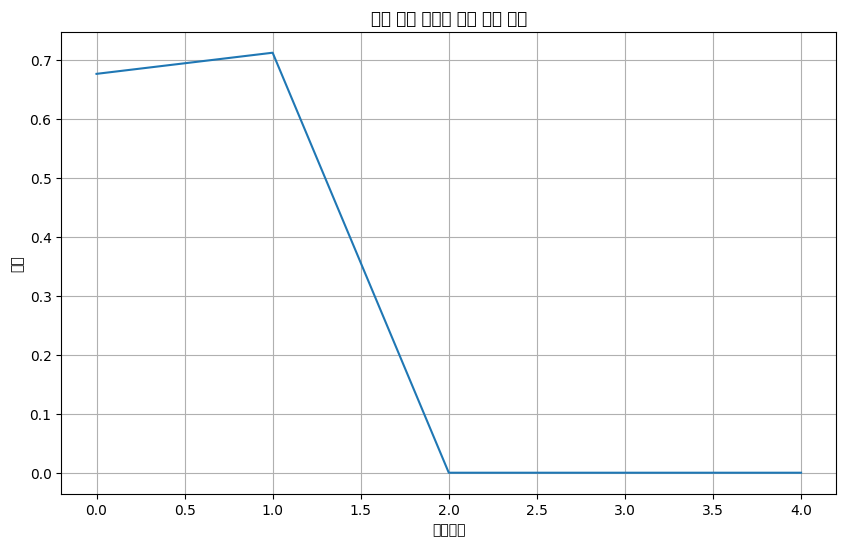

In [150]:
# 샘플 질의 및 정답을 사용하여 기본 RAG 파이프라인과 RL 기반 RAG 파이프라인의 성능을 비교합니다.
# 함수는 다음 값을 반환합니다:
# - simple_response: 기본 RAG 파이프라인이 생성한 응답
# - rl_response: RL 기반 RAG 파이프라인이 생성한 최상의 응답
# - simple_sim: 기본 RAG 응답과 정답 간의 유사도 점수
# - rl_sim: RL 기반 RAG 응답과 정답 간의 유사도 점수
simple_response, rl_response, simple_sim, rl_sim = compare_rag_approaches(sample_query, expected_answer)

## Saving the Comparison Results

In [151]:
# 나중에 비교할 수 있도록 결과를 저장합니다
results = {
    "query": query_text,  # 입력 질의
    "ground_truth": expected_answer,  # 해당 질의의 기대 정답
    "simple_rag": {
        "response": simple_response,  # 기본 RAG 파이프라인이 생성한 응답
        "similarity": float(simple_sim)  # 정답과의 유사도 점수
    },
    "rl_rag": {
        "response": rl_response,  # RL 기반 RAG 파이프라인이 생성한 응답
        "similarity": float(rl_sim)  # 정답과의 유사도 점수
    },
    "improvement": float(rl_sim - simple_sim)  # RL 기반 RAG로 인한 유사도 향상 정도
}

# 결과를 JSON 파일로 저장
with open('dataset/rl_rag_results.json', 'w') as f:
    json.dump(results, f, indent=2)  # 읽기 쉽게 들여쓰기하여 저장

# 저장 완료 메시지 출력
print("\n결과가 'rl_rag_results.json' 파일에 저장되었습니다.")


결과가 'rl_rag_results.json' 파일에 저장되었습니다.
